# Content

1. EDA
2. Data cleaning
3. Feature Engineering
4. Modeling & Evaluation
5. Model Ensemble

In [167]:
import pandas as pd
import numpy as np
import math
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import colors as mcolors
import random
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, RobustScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
import xgboost
import scipy.stats

from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_score

from catboost import CatBoostRegressor
from sklearn.linear_model import BayesianRidge, HuberRegressor, Ridge, OrthogonalMatchingPursuit, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from lightgbm import LGBMRegressor

from sklearn.decomposition import PCA
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone

In [168]:
from sklearn.linear_model import Lasso
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.svm import SVR, LinearSVR
from sklearn.linear_model import ElasticNet, SGDRegressor, BayesianRidge
from sklearn.kernel_ridge import KernelRidge
from xgboost import XGBRegressor

In [169]:
train_raw = pd.read_csv('./train.csv')
test_raw = pd.read_csv('./test.csv')

# EDA

In [170]:
train_raw.shape, test_raw.shape

((1460, 81), (1459, 80))

In [171]:
train_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

## Target

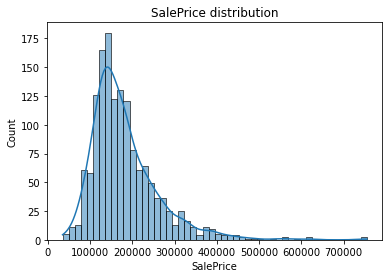

In [172]:
plt.figure()
sns.histplot(train_raw['SalePrice'], bins=50, kde=True)
plt.title('SalePrice distribution')
plt.show()

In [173]:
train_raw['SalePrice'].skew()

1.8828757597682129

- SalePrice is positive skewness, use log transformation to make it approximate normal distribution

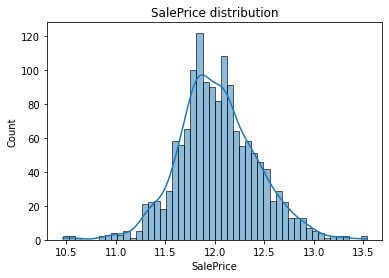

In [174]:
plt.figure()
sns.histplot(np.log1p(train_raw['SalePrice']), bins=50, kde=True)
plt.title('SalePrice distribution')
plt.show()

In [175]:
cate_features_eda = [col for col in train_raw.columns if train_raw[col].dtype == 'object']
num_features_eda = [col for col in train_raw.columns if train_raw[col].dtype == 'int64' or \
                      train_raw[col].dtype == 'float64']

num_features_eda.remove('Id')
num_features_eda.remove('SalePrice')

In [176]:
len(cate_features_eda), len(num_features_eda)

(43, 36)

## Categorical featrues

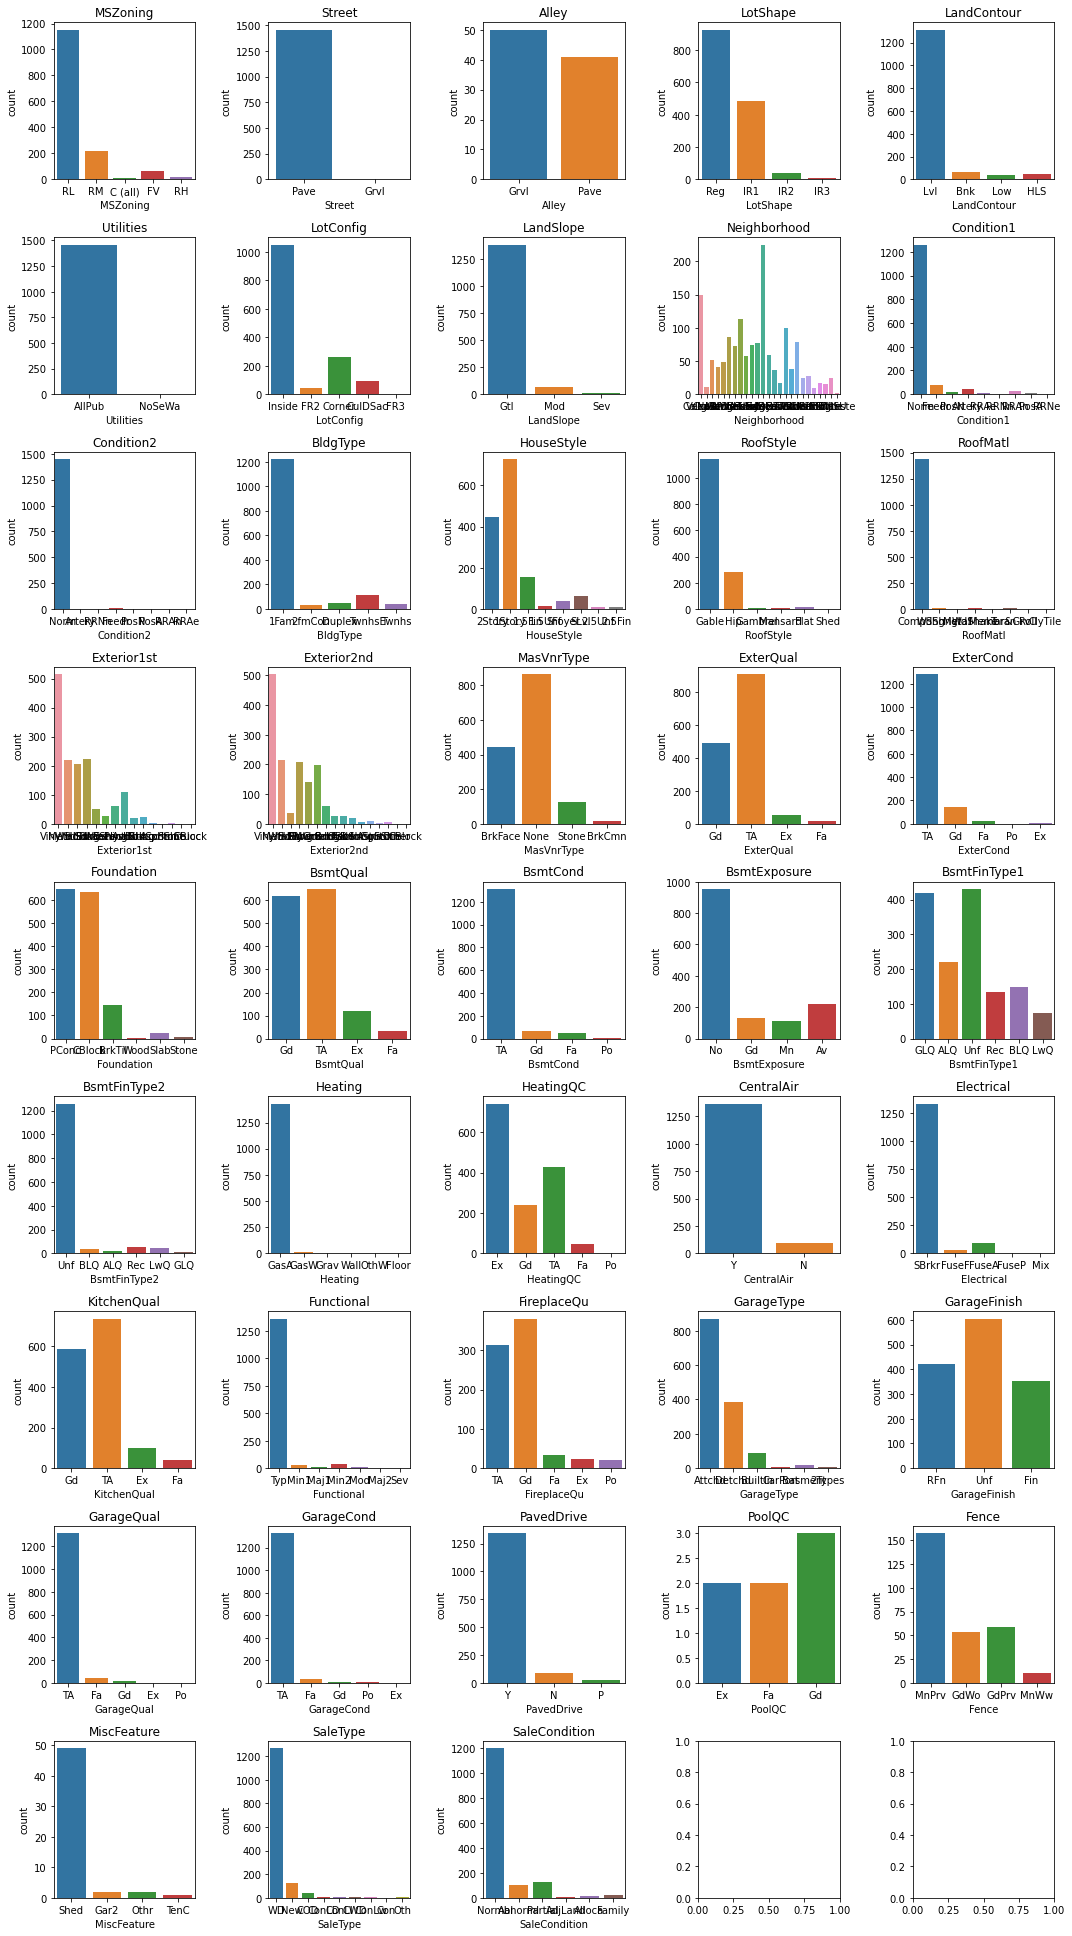

In [177]:
nrows, ncols = 9, 5
fix, axes = plt.subplots(nrows, ncols, figsize=(15, nrows * 3))

for i, feature in enumerate(cate_features_eda):
    # determine the location of subplot
    row, col = i // ncols, i % ncols
           
    sns.countplot(x=feature, data=train_raw, ax=axes[row, col])
    axes[row, col].set_title(feature)



plt.tight_layout()
plt.show()

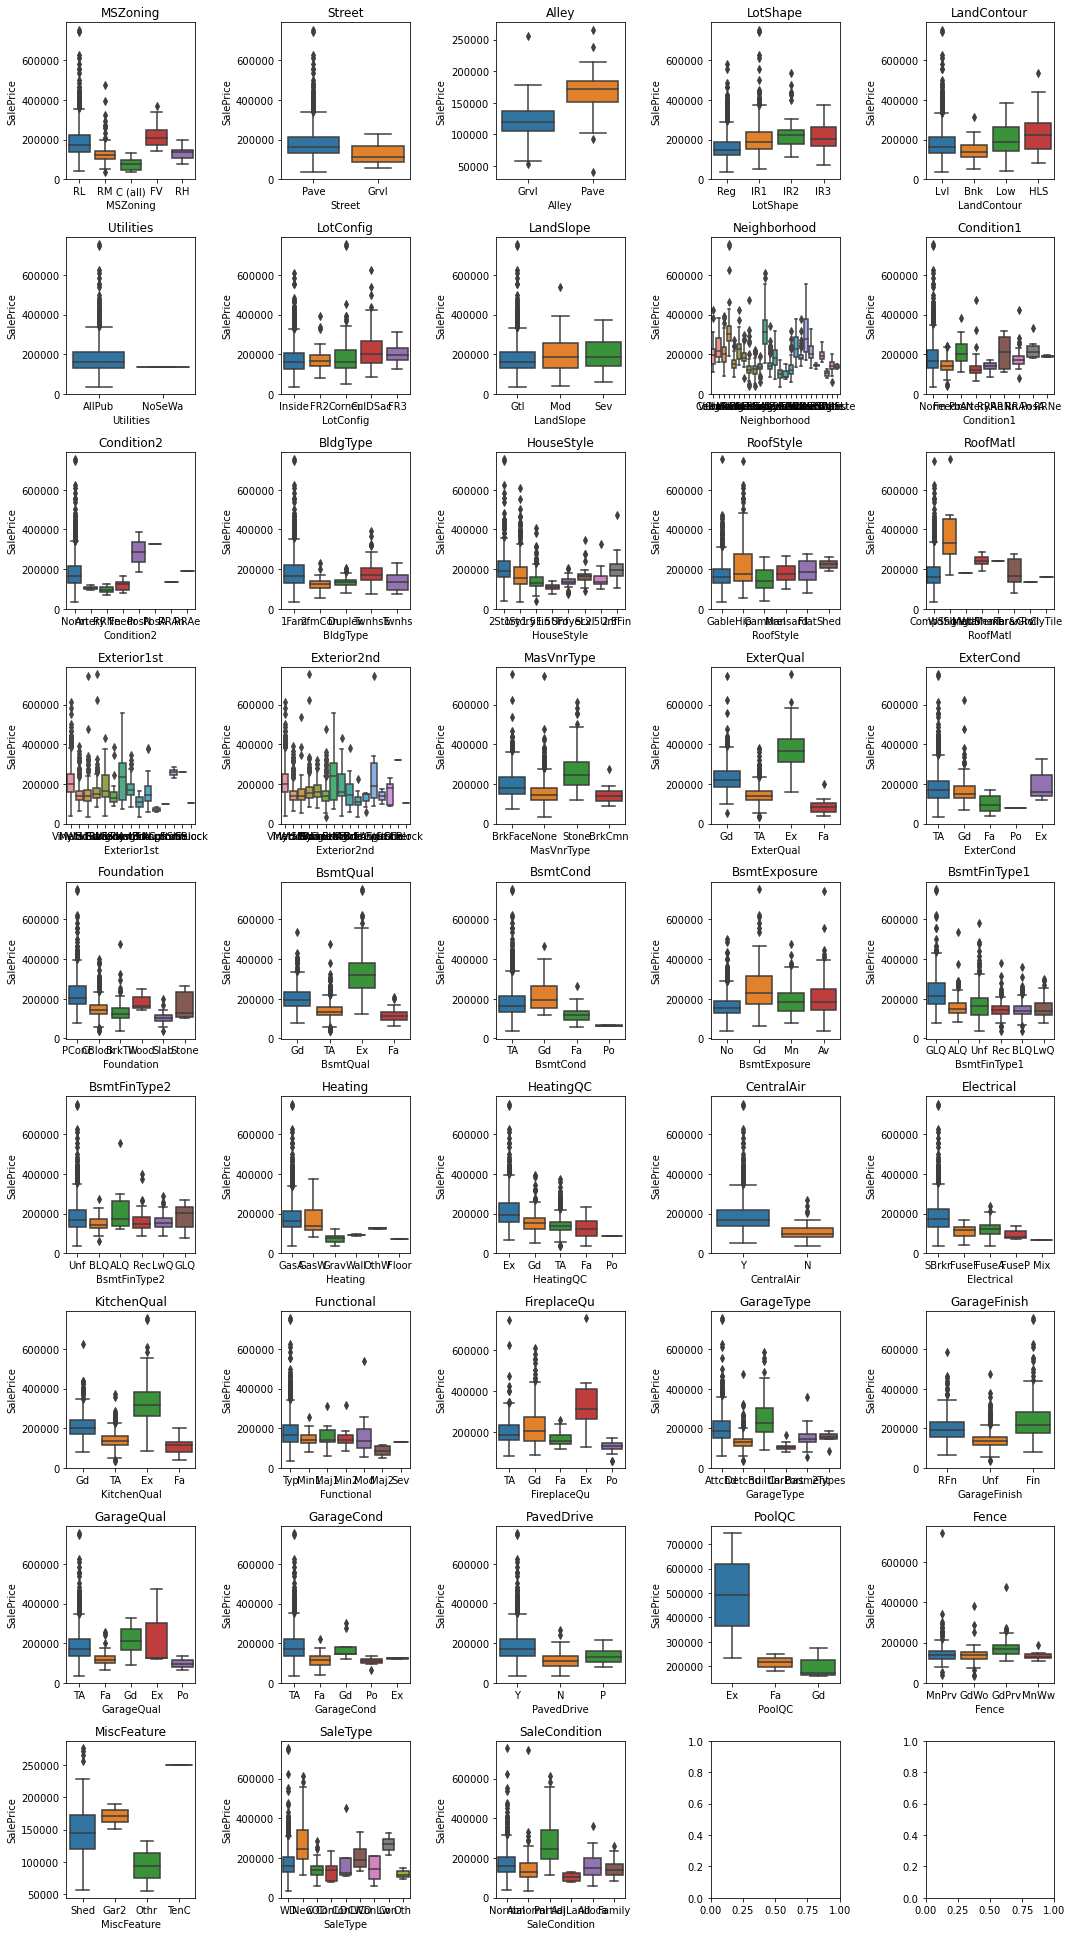

In [178]:
nrows, ncols = 9, 5
fig, axes = plt.subplots(nrows, ncols, figsize=(15, nrows * 3))

for i, feature in enumerate(cate_features_eda):
    # Determine the location of subplot
    row, col = i // ncols, i % ncols

    sns.boxplot(x=feature, y='SalePrice', data=train_raw, ax=axes[row, col])
    axes[row, col].set_title(feature)

plt.tight_layout()
plt.show()

- There is outliers in some features, we need to deal with them.

## Numerical features

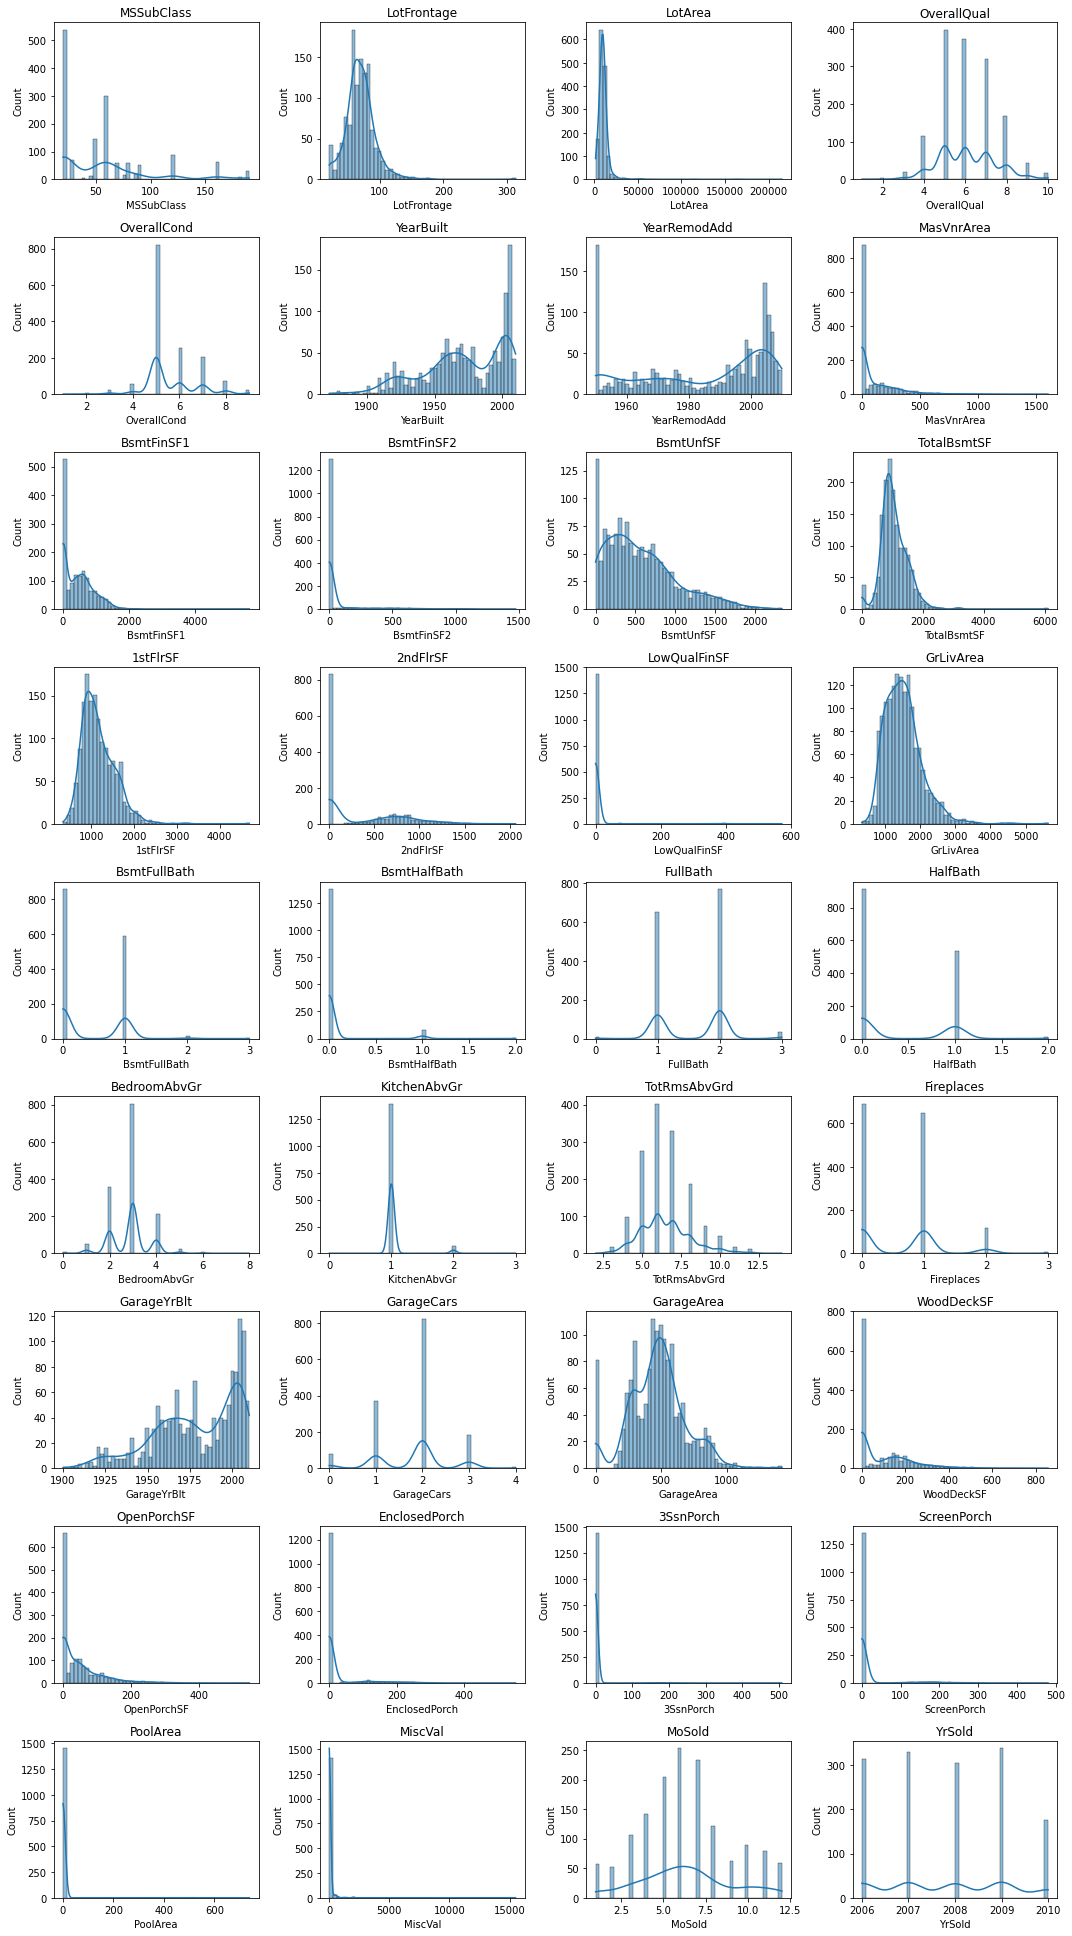

In [179]:
nrows, ncols = 9, 4
fix, axes = plt.subplots(nrows, ncols, figsize=(15, nrows * 3))

for i, feature in enumerate(num_features_eda):
    # determine the location of subplot
    row, col = i // ncols, i % ncols
           
    sns.histplot(train_raw[feature], bins=50, kde=True, ax=axes[row, col])
    axes[row, col].set_title(feature)



plt.tight_layout()
plt.show()

- It appears some features have lots of missing values
- Some features is skewness
- 'YearBuilt' and 'GarageYrBlt' can be encoded by label encoder

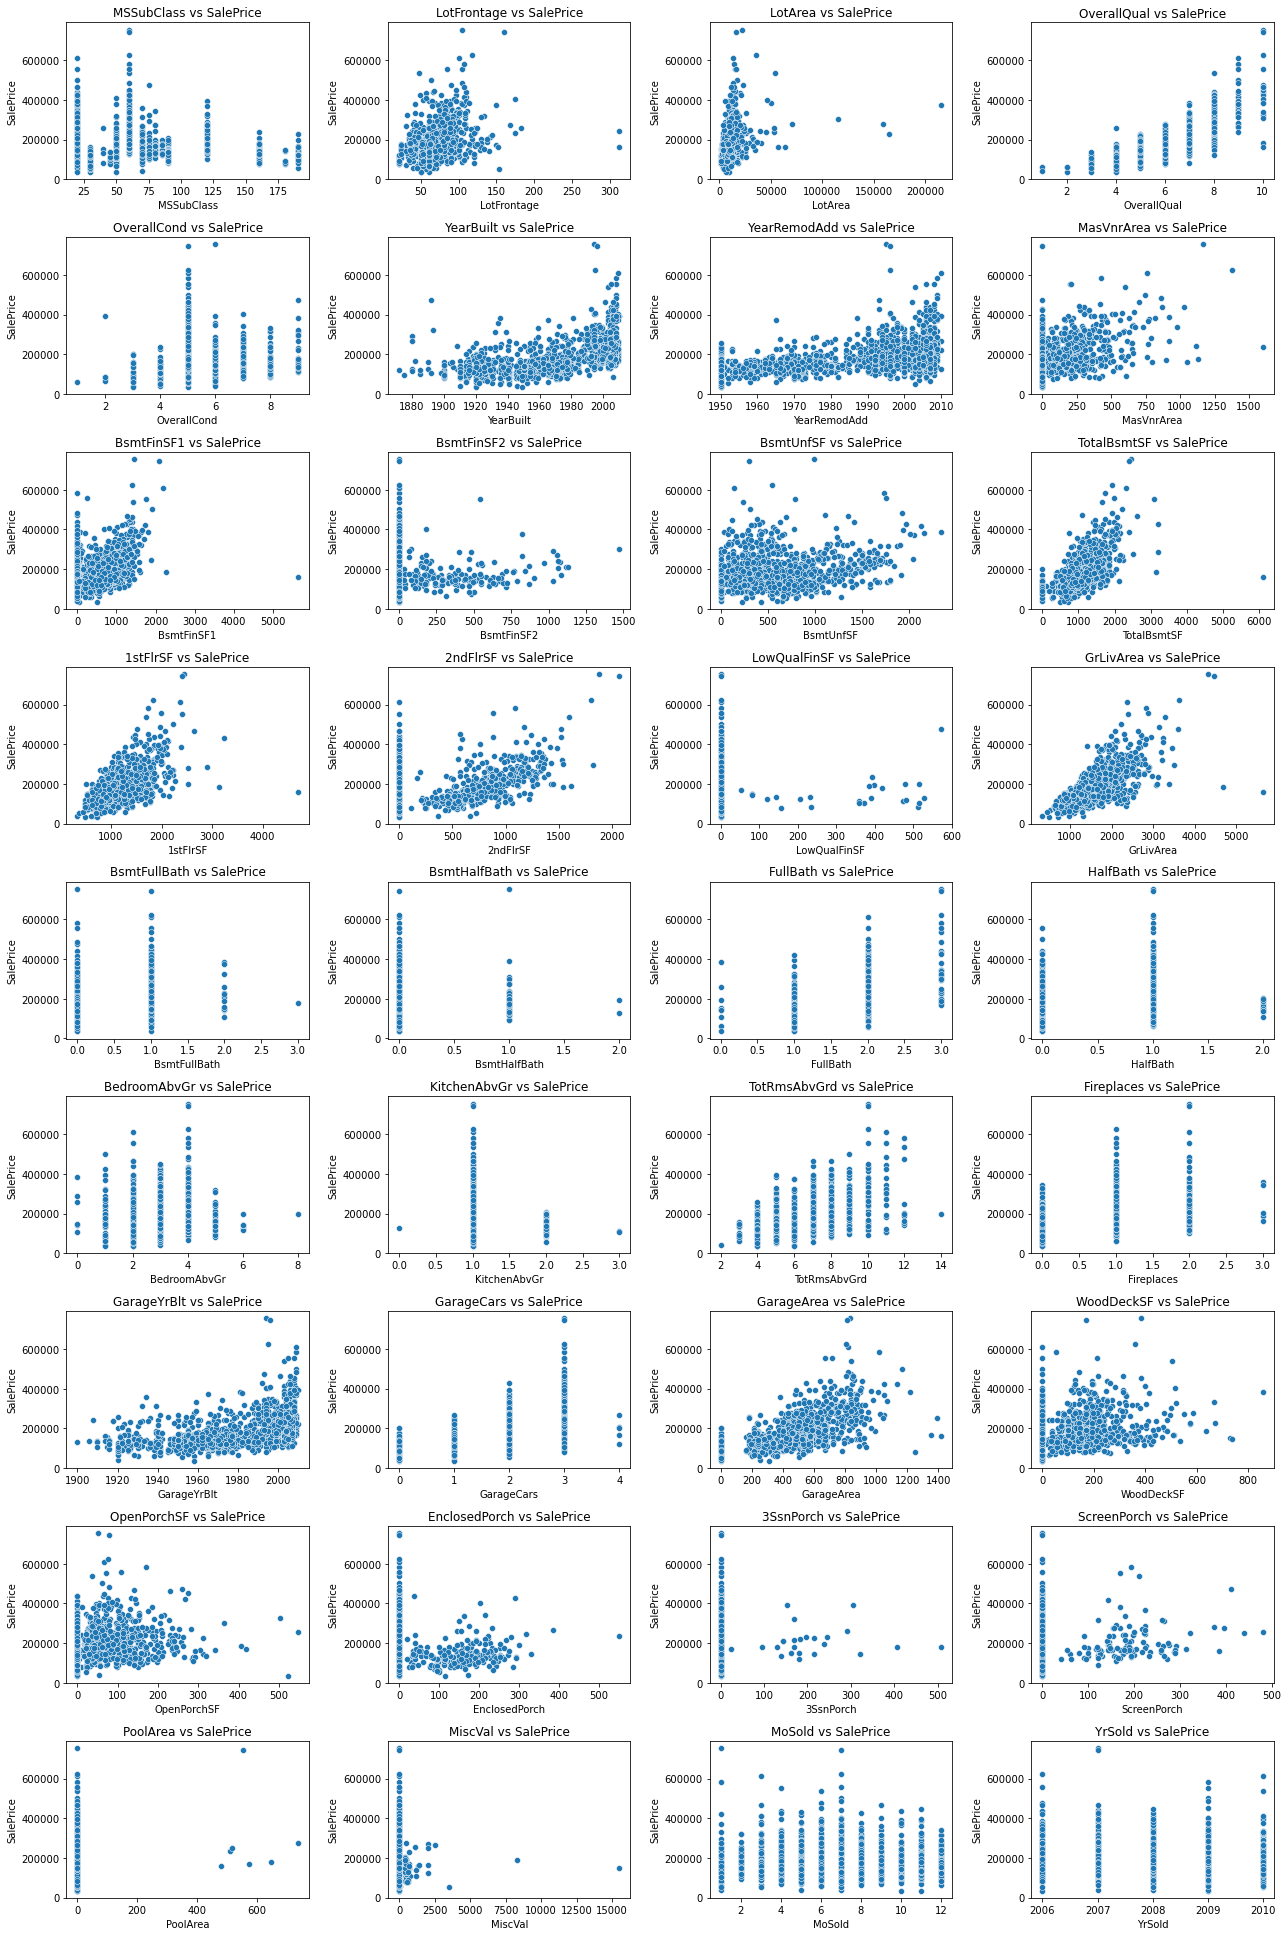

In [180]:
nrows, ncols = 9, 4
fix, axes = plt.subplots(nrows, ncols, figsize=(18, nrows * 3))

for i, feature in enumerate(num_features_eda):
    # determine the location of subplot
    row, col = i // ncols, i % ncols
           
    sns.scatterplot(x=feature, y='SalePrice', data=train_raw, ax=axes[row, col]) 
    

    
    ax=axes[row, col].set_title(f'{feature} vs SalePrice')

    
plt.tight_layout()
plt.show()

## Calculat the correlation of all features with target

### Encode categorical feature

In [181]:
def cate_encoder(df, feature_liset):

    cate_new_feature = []
    
    for feature in feature_liset:
        mean_saleprice = df.groupby([feature])['SalePrice'].mean()
        saleprice_order = pd.DataFrame(df.groupby(feature)['SalePrice'].mean()).reset_index()
        
        
        saleprice_order['rank'] = saleprice_order['SalePrice'].rank().astype(int)
        
        mapping = saleprice_order.set_index(feature)['rank'].to_dict()
        
        df[feature+'_encoded'] = df[feature].map(mapping)
        
        cate_new_feature.append(feature + '_encoded')
        
    return df, cate_new_feature

In [182]:
train_copy = train_raw.copy()
train_copy, cate_new_feature = cate_encoder(train_copy, cate_features_eda)

### Correlation

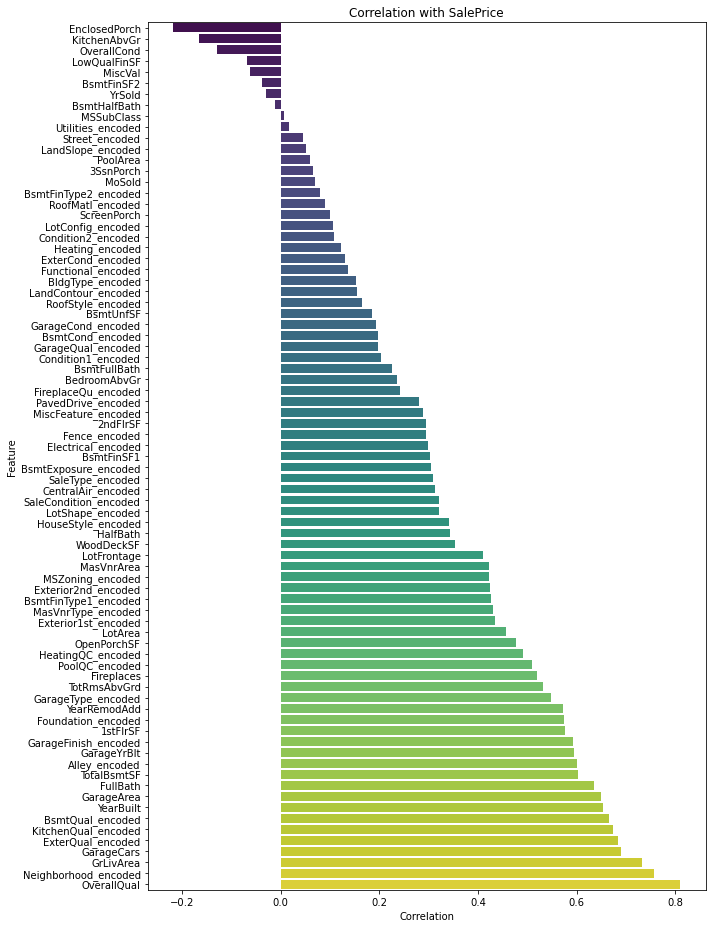

In [183]:
quantitative_features = cate_new_feature + num_features_eda + ['SalePrice']
corr_matrix = train_copy[quantitative_features].corr('spearman')
corr_df = corr_matrix['SalePrice'].reset_index()
corr_df.columns = ['Feature', 'Correlation']
corr_df = corr_df.sort_values('Correlation')
corr_df = corr_df[corr_df['Feature'] != 'SalePrice']

plt.figure(figsize=(10, 13))
sns.barplot(data=corr_df, x='Correlation', y='Feature', palette='viridis')
plt.title('Correlation with SalePrice')
plt.tight_layout()
plt.show()

# Data cleaning

## Outliers

The outliers in 'BsmtFinSF1, 'TotalBsmtSF', 'GrLivArea' will be eliminate

In [184]:
train_raw[train_raw['BsmtFinSF1'] > 4000]
# id 1299

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
1298,1299,60,RL,313.0,63887,Pave,NaN,IR3,Bnk,AllPub,...,480,Gd,NaN,NaN,0,1,2008,New,Partial,160000


In [185]:
train_raw[train_raw['TotalBsmtSF'] > 4000]
# id 1299

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
1298,1299,60,RL,313.0,63887,Pave,NaN,IR3,Bnk,AllPub,...,480,Gd,NaN,NaN,0,1,2008,New,Partial,160000


In [186]:
train_raw.loc[train_raw['GrLivArea'] > 4000, ['Id','GrLivArea','SalePrice']]
# id 1299 and 524

,Id,GrLivArea,SalePrice
523,524,4676,184750
691,692,4316,755000
1182,1183,4476,745000
1298,1299,5642,160000


In [187]:
train_raw = train_raw[~train_raw['Id'].isin([1299,524])]

In [188]:
train_raw.shape

(1458, 81)

## Missing values

In [189]:
df_train = train_raw.drop(['SalePrice'], axis=1)

full_data = pd.concat([df_train, test_raw], axis=0, ignore_index=True)

In [190]:
def show_missing_value_percentage(df):
    missing_data = pd.DataFrame()
    total_id = len(df)
    
    try:
        for col in df.columns:
            null_num = df[col].isnull().sum()
            if null_num > 0:
                percentage = (df[col].isnull().sum() / total_id)*100
                percentage_str = '{:.1f}%'.format(percentage)
                missing_data_temp = pd.DataFrame({'null_num': [null_num], 'Percentage': [percentage_str]}, index=[col])
                missing_data = pd.concat([missing_data, missing_data_temp], axis = 0)
        return missing_data.sort_values('null_num', ascending=False)
    except:
        print('no missing value')


In [191]:
show_missing_value_percentage(full_data)

,null_num,Percentage
PoolQC,2908,99.7%
MiscFeature,2812,96.4%
Alley,2719,93.2%
Fence,2346,80.4%
FireplaceQu,1420,48.7%
LotFrontage,486,16.7%
GarageFinish,159,5.5%
GarageQual,159,5.5%
GarageCond,159,5.5%
GarageYrBlt,159,5.5%


### Impute LotFrontage by higher correlated features and domain knowledge

featrues that high correlated with 'LotFrontage'

In [196]:
train_copy[quantitative_features].corr('spearman')['LotFrontage'].sort_values(ascending=False).head(15)

LotFrontage             1.000000
LotArea                 0.649633
1stFlrSF                0.427678
SalePrice               0.409076
TotalBsmtSF             0.386206
BldgType_encoded        0.382984
GarageArea              0.378052
GrLivArea               0.375844
TotRmsAbvGrd            0.365999
GarageCars              0.351756
GarageType_encoded      0.348671
BedroomAbvGr            0.327679
Neighborhood_encoded    0.323136
MSZoning_encoded        0.302206
GarageFinish_encoded    0.260403
Name: LotFrontage, dtype: float64

Domain:
Since the area of each street connected to the house property most likely have a similar area to other houses in its neighborhood , we can fill in missing values by the median LotFrontage of the neighborhood.

In [ ]:
train_copy.groupby